# Neural Network Learning

I will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition with the weights that were provided

In [27]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
input_layer_size = 400   # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

In [29]:
# Load Training Data
mat_data = loadmat('4. Neural Networks Learning/ex4/ex4data1.mat')
X = mat_data['X']
y = mat_data['y'].ravel()
print('X.shape',X.shape)
m, n = X.shape

input_layer_size = 400   # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

print('Neural Network Input layer size (20x20 pixels)',input_layer_size) 
print('Hidden layer size', hidden_layer_size)
print('Number of labels',num_labels)

X.shape (5000, 400)
Neural Network Input layer size (20x20 pixels) 400
Hidden layer size 25
Number of labels 10


In [30]:
mat_param = loadmat('4. Neural Networks Learning/ex4/ex4weights.mat')
theta_1 = mat_param['Theta1']
theta_2 = mat_param['Theta2']
print('theta1 :', theta_1.shape,'theta2 :', theta_2.shape)

# Unroll parameters
params_trained = np.hstack((theta_1.flatten(), theta_2.flatten()))
print('params :', params_trained .shape,'\n')


theta1 : (25, 401) theta2 : (10, 26)
params : (10285,) 



Let's first define a few variables that we will need to use:

    L = total number of layers in the network
    s_l = number of units (not counting bias unit) in layer l
    K = number of output units/classes


I assume that the neural network will only have 3 layers – an input
layer, a hidden layer and an output layer.

**Cost Function** 
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$


**Regularized Cost Function**
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}(\Theta_{ji}^{(l)})^2\bigg]$$


Now for the formula: (note that the formula is for a whole batch of m input samples).

The summation symbol is just another way of writing a for-loop so what the three summations means is this: for each layer l and for every pair of connecting units i and j, take the square of the weight from j to i, then add everything

 
Regularized Cost Function
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

The `nn_cost_function()` implements the neural network cost function for a two layer neural network which performs classification.

In [31]:
cost_history = []
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, l):
    
    Theta_1 = np.reshape(nn_params[0:(hidden_layer_size * (input_layer_size + 1)), ],
                         (hidden_layer_size, input_layer_size + 1))
    Theta_2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):, ],
                         (num_labels, hidden_layer_size + 1))

    m, n = X.shape
    X = np.hstack((np.ones((m, 1)), X))
    #print('X',X.shape)
    Z_2 = X.dot(Theta_1.T)
    A_2 = sigmoid(Z_2)
    A_2 = np.hstack((np.ones((m, 1)), A_2))

    Z_3 = A_2.dot(Theta_2.T)
    A_3 = sigmoid(Z_3)

    '''Y = np.zeros((m, num_labels))
    for i in range(m):
        Y[i, y[i] - 1] = 1'''
    
    Y = pd.get_dummies(y.ravel()).as_matrix() 
                
    j = np.trace(-np.dot(Y.T,np.log(A_3))-np.dot((1-Y.T),np.log(1-A_3)))/m
    j += l*np.sum(np.square(Theta_1[:,1:]))/(2*m)+l*np.sum(np.square( Theta_2[:,1:]))/(2*m)
    
    cost_history.append(j)
    
        
    grad = BackpropagationUpdates(A_3,A_2,Y,X,Theta_2,Theta_1,Z_2,m)
    return j, grad


I will implement the backpropagation algorithm. Recall that
the intuition behind the backpropagation algorithm is as follows. Given a
training example (x(t),y(t)), we will first run a “forward pass” to compute
all the activations throughout the network, including the output value of the
hypothesis hΘ(x).

Then, for each node j in layer l, we would like to compute
an “error term” δ that measures how much that node was “responsible”
for any errors in our outpuT.

**1.** For each output unit k in layer 3 (the output layer).

$$ \delta_{K}^{(3)} = a_{K}^{(3)}-y_k $$

**2.** For the hidden layer l = 2
$$ \delta^{(2)} = \big(\theta^{(2)}\big)^{T} \delta^{(3)}.* g^{'}\big(z^{(2)}\big)$$

**3.** Accumulate the gradient from this example using the following formula.

$$ \Delta^{(l)} := \Delta^{(l)}+\delta^{(l+1)}\big(a^{(l)}\big)^{T}$$

**4.** Hence we update our new Δ matrix.

$$ D_{i,j}^{(l)}= \big(\Delta_{(i,j)}^{(l)}+\lambda \theta_{i,j}^{(l)}\big)$$



In [32]:
def BackpropagationUpdates(A_3,A_2,Y,X,Theta_2,Theta_1,Z_2,m):
   
    d_3 = A_3 - Y
    delta2 = d_3.T.dot(A_2)

    Z_2 = np.hstack((np.ones((m, 1)), Z_2))
    d_2 = d_3.dot(Theta_2) * sigmoid_gradient(Z_2)
    d_2 = d_2[:, 1:]
    delta1 = d_2.T.dot(X)

    Theta_1_grad = 1.0 * delta1 / m
    Theta_1_grad[:, 1:] = Theta_1_grad[:, 1:] + 1.0 * l / m * Theta_1[:, 1:]

    Theta_2_grad = 1.0 * delta2/ m
    Theta_2_grad[:, 1:] = Theta_2_grad[:, 1:] + 1.0 * l / m * Theta_2[:, 1:]

    grad = np.hstack((Theta_1_grad.ravel(), Theta_2_grad.ravel()))

    return grad

The nn_cost_function() implements the neural network cost function for a two layer neural network which performs classification.

Sigmoid gradient
$$ g'(z) = g(z)(1 - g(z))$$
where 
$$ g(z) = \frac{1}{1+e^{-z}}$$


In [33]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g


def sigmoid_gradient(z):
    g = sigmoid(z) * (1 - sigmoid(z))
    return g

Compute the cost at the parameters loaded from `ex4weights.mat`:

In [34]:
l = 0.0
print('X',X.shape)
print('Cost function for neural networks without regularization',\
      nn_cost_function(params_trained, input_layer_size, hidden_layer_size, num_labels, X, y, l)[0])

X (5000, 400)
Cost function for neural networks without regularization 0.28762916516131887


/home/johan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Compute the cost at the parameters loaded from `ex4weights.mat` with regularization parameter set to 1.0: 

In [35]:
l = 1.0
print('X',X.shape)
print('Cost function for neural networks without regularization',\
      nn_cost_function(params_trained, input_layer_size, hidden_layer_size, num_labels, X, y, l)[0])

X (5000, 400)
Cost function for neural networks without regularization 0.3837698590909236


/home/johan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Evaluating sigmoid gradient:

In [36]:
g = sigmoid_gradient(np.array([-1, -0.5, 0, 0.5, 1]))
print ('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:')
print (g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


When training neural networks, it is important to randomly initialize the pa- rameters for symmetry breaking. One effective strategy for random initializa- tion is to randomly select values for Θ (l) uniformly in the range [−epsilon_init , epsilon_init ]. You should use epsilon_init = 0.12


In [37]:
def rand_initialize_weights(l_in, l_out):
    #Randomly initialize the weights of a layer with l_in incoming connections and l_out outgoing connections.
    epsilon_init = 0.12

    # Note that w should be set to a matrix of size(l_out, 1 + l_in) as the first column of W handles the "bias" terms
    W = np.random.rand(l_out, 1 + l_in) * 2 * epsilon_init - epsilon_init

    return W

Randomly initializing neural network parameters:

In [38]:
initial_theta_1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
initial_theta_2 = rand_initialize_weights(hidden_layer_size, num_labels)
initial_nn_params = np.hstack((initial_theta_1.ravel(), initial_theta_2.ravel()))

print('initial_theta_1 :', initial_theta_1.shape)
print('initial_theta_2 :', initial_theta_2.shape)
print('initial_nn_params :', initial_nn_params.shape)

initial_theta_1 : (25, 401)
initial_theta_2 : (10, 26)
initial_nn_params : (10285,)


Check backpropagation with regularization parameter set to 3.0:

In [39]:
l = 3.0
debug_j, _ = nn_cost_function(params_trained, input_layer_size, hidden_layer_size, num_labels, X, y, l)
print ('Cost at (fixed) debugging parameters (w/ lambda = {}): {}'.format(l, debug_j))

Cost at (fixed) debugging parameters (w/ lambda = 3.0): 0.5760512469501331


/home/johan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


With `nn_cost_function()` and randomly initialized parameters, we can train the neural network.

In [40]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

import scipy.optimize as opt

result = opt.minimize(fun=nn_cost_function, x0=initial_nn_params,
                      args=(input_layer_size, hidden_layer_size, num_labels, X, y, l),
                      method='TNC', jac=True, options={'maxiter': 150})
params_trained = result.x
Theta_1_trained = np.reshape(params_trained[0:(hidden_layer_size * (input_layer_size + 1)), ],
                             (hidden_layer_size, input_layer_size + 1))
Theta_2_trained = np.reshape(params_trained[(hidden_layer_size * (input_layer_size + 1)):, ],
                             (num_labels, hidden_layer_size + 1))

/home/johan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(0, 6.859656383812468)

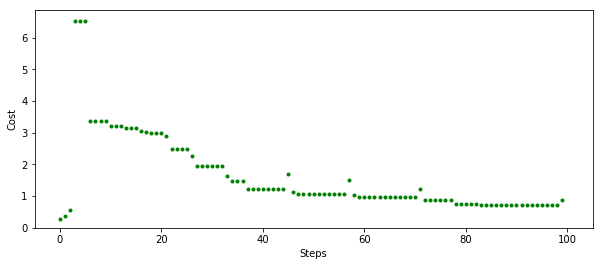

In [41]:
num_steps = 100
plt.figure()
fig = plt.figure(figsize=(10, 4))
plt.plot(np.array(cost_history[:num_steps]), '.g', linewidth=0.2)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.xlim(-num_steps * 0.05, num_steps * 1.05)
plt.ylim(0, max(cost_history[:num_steps]) * 1.05)


**Visualizing the hidden layer**

One way to understand what your neural network is learning is to visualize
what the representations captured by the hidden units.

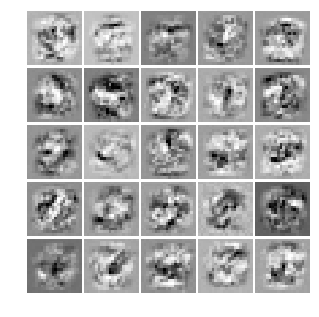

In [42]:
import matplotlib.gridspec as gridspec

L = hidden_layer_size+1
N = X.shape[1] # = 5000 sample

dim = int(np.sqrt(L - 1)) # L = dim x dim + 1, where the 1 counts the bias term.

theta_1_learned = params_trained[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)

fig = plt.figure(figsize=(4, 4))

#gridspec is a module which specifies the location of the subplot in the figure.
#A class that specifies the geometry of the grid that a subplot will be placed.

gs = gridspec.GridSpec(dim, dim)
gs.update(bottom=0.01, top=0.99, left=0.01, right=0.99, 
          hspace=0.05, wspace=0.05)

k = 0
for i in range(dim):
    for j in range(dim):
        ax = plt.subplot(gs[i, j])
        ax.axis('off')
        ax.imshow(Theta_1_trained[k][1:].reshape(int(np.sqrt(N)), int(np.sqrt(N))).T,
                 cmap=plt.get_cmap('Greys'), 
                 interpolation = 'nearest')
        k += 1


Now is time to do a prediction. The `predict()` function predicts the label of an input given a trained neural network.

In [43]:
def predict(Theta_1, Theta_2, X):
    
    m, n = X.shape
    X = np.hstack((np.ones((m, 1)), X))
    A_2 = sigmoid(X.dot(Theta_1.T))
    A_2 = np.hstack((np.ones((m, 1)), A_2))
    A_3 = sigmoid(A_2.dot(Theta_2.T))

    p = np.argmax(A_3, axis=1)
    p += 1  # The theta_1 and theta_2 are loaded from Matlab data, in which the matrix index starts from 1.

    return p

pred = predict(Theta_1_trained, Theta_2_trained, X)
print ('Training Set Accuracy:', np.mean(pred == y) * 100)


Training Set Accuracy: 96.7
